## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt   
from matplotlib.pyplot import cm


## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [2]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))
dfexpX = load_dfall[load_dfall.columns[4:-1]]
num_sample = load_rst_npy.shape[0]

In [3]:
allrst_max = np.zeros((num_sample, 1))
for ii in range(num_sample):
    allrst_max[ii,0] = np.max(load_rst_npy[ii,:,:,:])

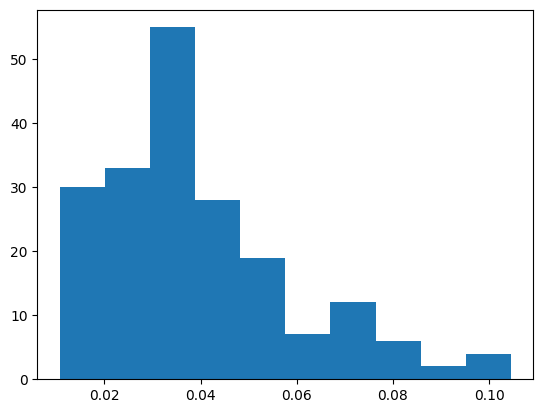

In [4]:
plt.hist(allrst_max)
plt.show()

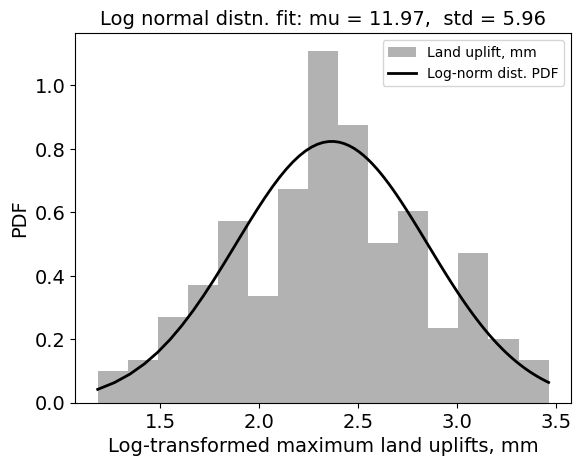

In [30]:
from scipy.stats import norm


CO2size = allrst_max*304.8

# Fit a normal distribution to the data:
mu, std = norm.fit(CO2size)
log_mu, log_std = norm.fit(np.log(CO2size))

x = np.linspace(min(CO2size), max(CO2size), 100)
p = norm.pdf(x, mu, std)
log_p = (norm.pdf(np.log(x), log_mu, log_std))
# plt.hist((CO2size), bins=25, density=True, alpha=0.6, color='gray', label='Land uplift, mm')
# plt.plot(x, p, 'k', linewidth=2, label='Norm dist. PDF')

plt.hist(np.log(CO2size), bins=15, density=True, alpha=0.6, color='gray', label='Land uplift, mm')
plt.plot(np.log(x), log_p, 'k', linewidth=2, label='Log-norm dist. PDF')

plt.xlabel('Log-transformed maximum land uplifts, mm', fontsize=14)
plt.ylabel('PDF', fontsize=14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
title = f"Log normal distn. fit: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title, fontsize=14)
plt.legend()
plt.legend(prop={'size': 10})
plt.show()

## For 0D case

In [42]:
parameters = dfexpX.values
responses = allrst_max

parameter_names = dfexpX.columns.to_list()

In [43]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [44]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [45]:
from pyDGSA.dgsa import dgsa


mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.848156    0.325310
E_sand, psi           2.296060    1.016617
v_shale               0.522626    0.241043
v_sand                0.807109    0.341739
kvkh                  0.538128    0.238245
inj_rate, ft3/day     1.920410    0.845491
inj_hrzn, year        0.295504    0.122395


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [46]:
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3
E_shale, psi       1.490838  0.536352  1.261639
E_sand, psi        4.041572  1.376555  3.346900
v_shale            0.883728  0.819743  0.289393
v_sand             1.442958  0.451135  1.282177
kvkh               0.880021  0.243279  0.971116
inj_rate, ft3/day  3.466876  1.094959  2.887212
inj_hrzn, year     0.244163  0.518093  0.398670


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [47]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       1.806107
inj_rate, ft3/day | E_sand, psi       1.781816
E_sand, psi | E_shale, psi            0.954782
inj_hrzn, year | kvkh                 0.866318
kvkh | inj_hrzn, year                 0.792539
v_sand | E_shale, psi                  0.77226
kvkh | v_shale                        0.726332
v_sand | kvkh                         0.725612
inj_rate, ft3/day | v_shale           0.708576
E_shale, psi | v_shale                0.664219
inj_rate, ft3/day | E_shale, psi      0.659974
E_sand, psi | v_shale                 0.657933
E_sand, psi | v_sand                   0.64232
inj_rate, ft3/day | v_sand            0.604867
kvkh | E_sand, psi                    0.601829
kvkh | E_shale, psi                   0.601578
E_shale, psi | kvkh                   0.593418
E_shale, psi | v_sand                 0.584425
v_sand | v_shale                      0.578776
kvkh | inj_rate, ft3/day              0.567451
inj_hrzn, yea

Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [48]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi        1.43906
E_sand, psi | inj_rate, ft3/day       1.404394
E_sand, psi | E_shale, psi            0.944005
E_shale, psi | E_sand, psi            0.843433
E_shale, psi | inj_rate, ft3/day      0.818865
E_sand, psi | v_shale                 0.797778
kvkh | v_shale                         0.79537
E_sand, psi | v_sand                  0.793036
E_shale, psi | v_sand                 0.778953
v_sand | E_sand, psi                  0.771465
inj_hrzn, year | kvkh                 0.748255
E_shale, psi | v_shale                0.740837
E_shale, psi | kvkh                   0.736722
kvkh | v_sand                          0.72641
kvkh | inj_hrzn, year                 0.724248
inj_rate, ft3/day | v_shale           0.689497
v_sand | v_shale                      0.658982
inj_rate, ft3/day | E_shale, psi      0.649115
inj_rate, ft3/day | v_sand            0.648648
v_sand | E_shale, psi                 0.646531
v_shale | E_s

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [49]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3
E_sand, psi | E_shale, psi           1.46313  0.598578  0.794063
v_shale | E_shale, psi              0.510047  0.518092  0.590891
v_sand | E_shale, psi               0.797763  0.938307  0.583082
kvkh | E_shale, psi                 0.674783  0.642273  0.487221
inj_rate, ft3/day | E_shale, psi    0.824704  0.595455  0.562407
inj_hrzn, year | E_shale, psi       0.659702  0.585902  0.379779
E_shale, psi | E_sand, psi          0.366851  0.621802  0.476558
v_shale | E_sand, psi               0.503778  0.635403  0.469254
v_sand | E_sand, psi                0.629405  0.330357  0.621431
kvkh | E_sand, psi                  0.606334  0.646603  0.556233
inj_rate, ft3/day | E_sand, psi     1.917755  2.601866  0.738115
inj_hrzn, year | E_sand, psi         0.26832  0.567765  0.447514
E_shale, psi | v_shale              0.666696  0.606525  0.731499
E_sand, psi | v_shale               0.568163   0.68707  0.708455
v_sand | v_shale         

To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [50]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi          1.750023   1.01556  1.685626  0.713368   
v_shale | E_shale, psi              0.109164   0.80766  0.615926  0.202632   
v_sand | E_shale, psi               0.286995  1.227628  0.864663  0.856019   
kvkh | E_shale, psi                 0.506727  0.857893  0.657439   0.45862   
inj_rate, ft3/day | E_shale, psi    1.127946  0.665135  0.730366  0.665088   
inj_hrzn, year | E_shale, psi       0.754166  0.621259  0.601621  0.523401   
E_shale, psi | E_sand, psi               NaN  0.334632  0.409954  0.541173   
v_shale | E_sand, psi                    NaN   0.48243  0.541128  0.651965   
v_sand | E_sand, psi                     NaN  0.622075  0.661654  0.309707   
kvkh | E_sand, psi                       NaN  0.548235  0.644244   0.53313   
inj_rate, ft3/day | E_sand, psi          NaN  1.985748  1.972585

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

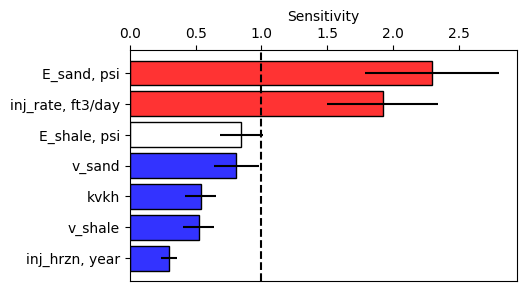

In [76]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+7', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

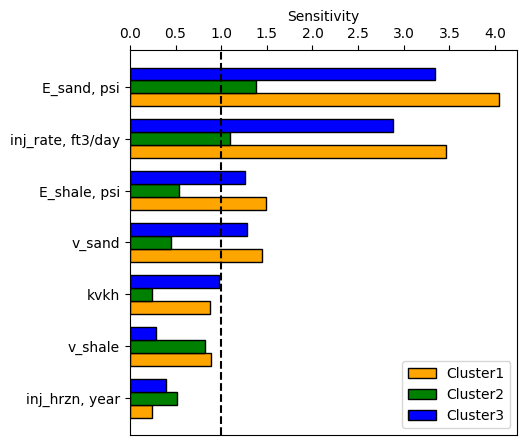

In [77]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'blue', 'red', 'black']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=7, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

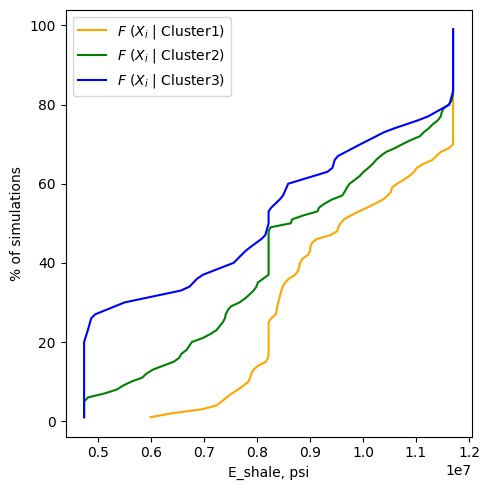

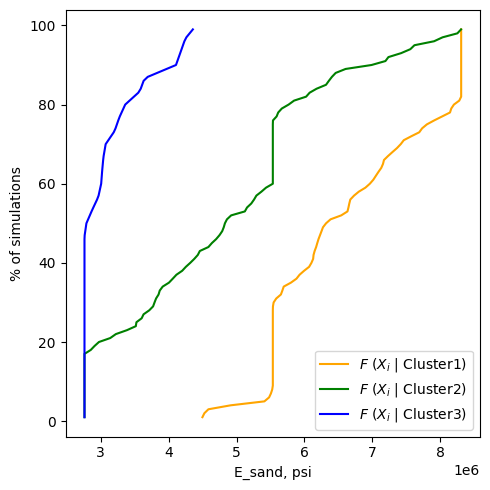

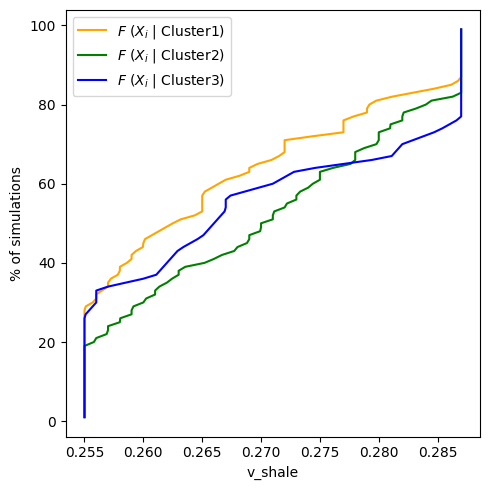

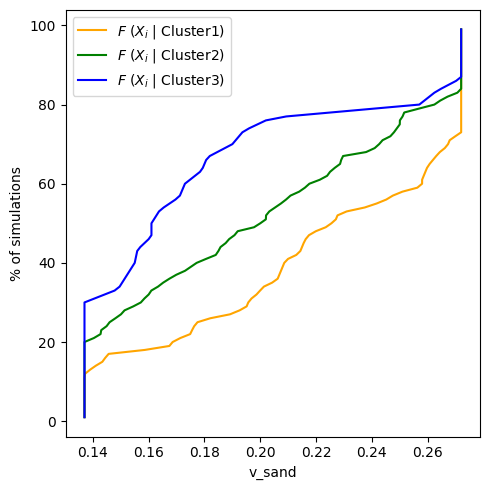

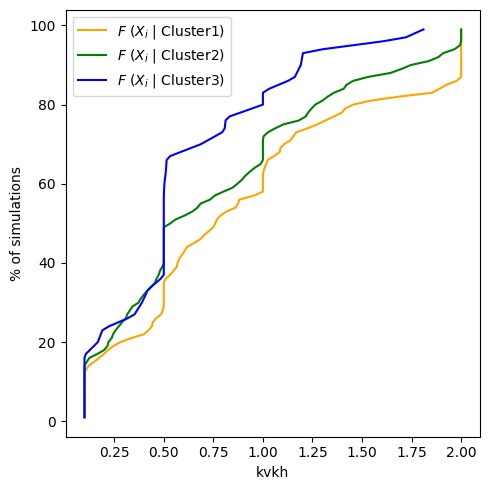

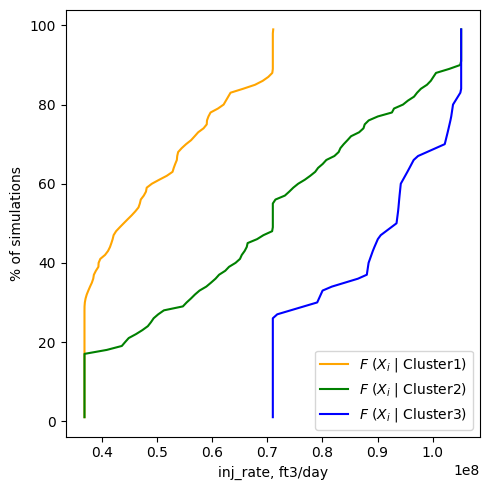

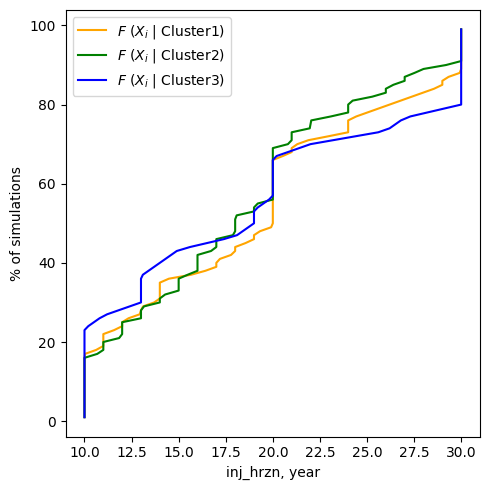

In [78]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

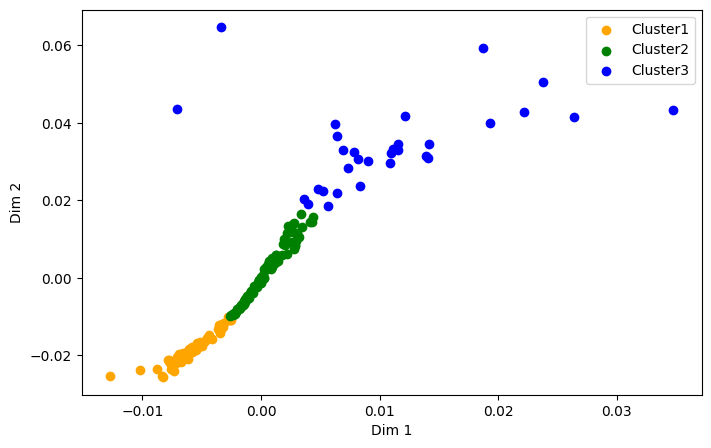

In [79]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

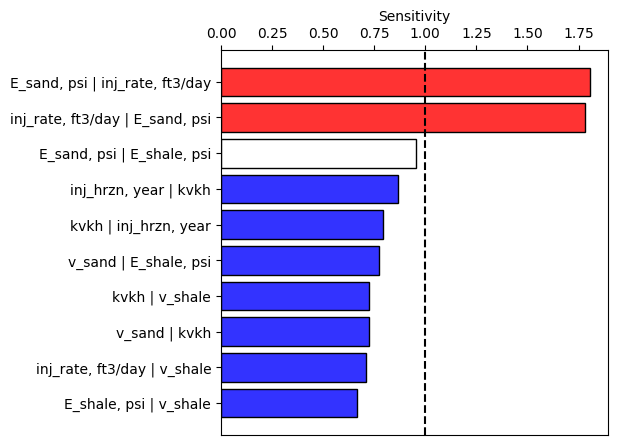

In [85]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

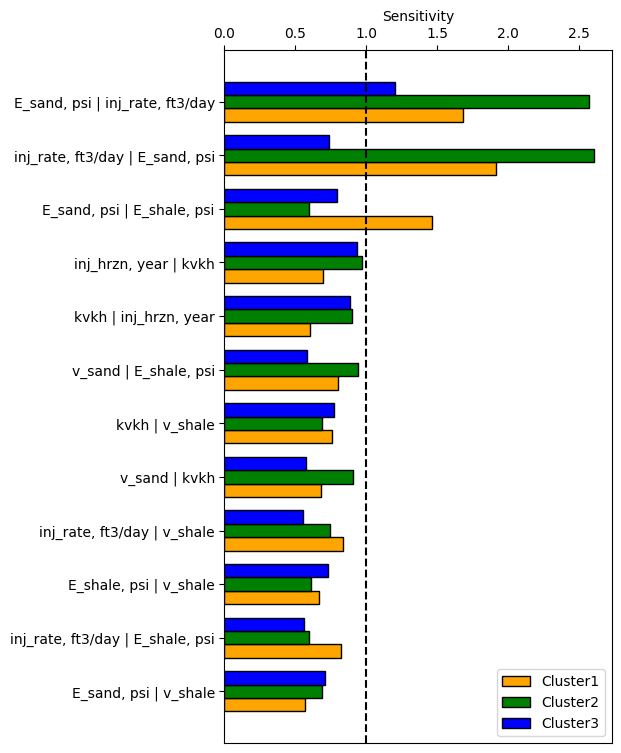

In [86]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           np_plot = '+8',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

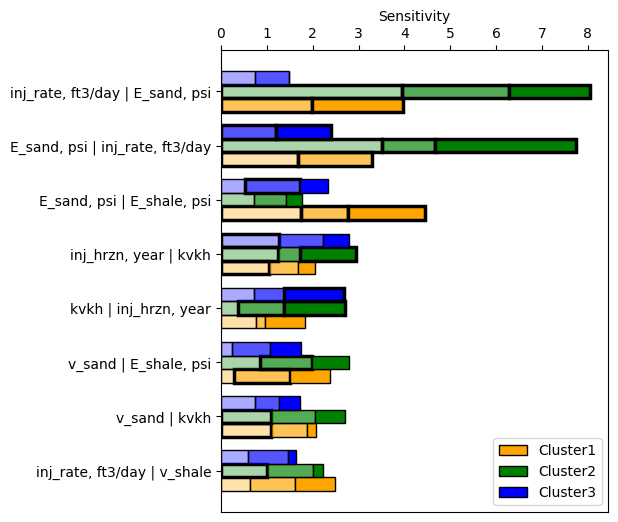

In [87]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)